# eda de videojuegos: guia y objetivos

este notebook realiza un analisis exploratorio sobre la base `Video_Games.csv`.
objetivos:
- entender los juegos mas vendidos consolidando versiones en distintas plataformas.
- analizar la distribucion de ventas por genero y por region (norte america, europa, japon).
- ver que plataformas y publishers concentran mas ventas.
- observar la dinamica temporal de las ventas por año.

nota: las ventas se interpretan como millones de unidades.


## carga y primer vistazo

aqui cargamos el csv y mostramos las primeras filas para confirmar columnas clave.
mostrando: name, platform, genre, year_of_release, global_sales, na_sales, eu_sales, jp_sales, publisher, user_score.

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- carga y limpieza de datos ---
# antes de analizar, es crucial preparar los datos. en esta seccion, cargamos el archivo,
# limpiamos los nombres de las columnas, convertimos los tipos de datos a numericos
# y manejamos valores faltantes para asegurar la calidad de nuestro analisis.

df = pd.read_csv("C:/Users/Sam/Downloads/Video_Games.csv", low_memory=False)
# limpiar nombres de columnas
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# convertir columnas de ventas a numerico
sales_cols = ["Global_Sales", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
for c in sales_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# convertir user_score a numerico
if "User_Score" in df.columns:
    df["User_Score"] = pd.to_numeric(df["User_Score"], errors='coerce')

# eliminar filas sin datos basicos
df = df.dropna(subset=["Name", "Platform", "Genre","Critic_Score"])

print(df.head())

                    Name Platform  Year_of_Release     Genre Publisher  \
0             Wii Sports      Wii           2006.0    Sports  Nintendo   
2         Mario Kart Wii      Wii           2008.0    Racing  Nintendo   
3      Wii Sports Resort      Wii           2009.0    Sports  Nintendo   
6  New Super Mario Bros.       DS           2006.0  Platform  Nintendo   
7               Wii Play      Wii           2006.0      Misc  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
6     11.28      9.14      6.50         2.88         29.80          89.0   
7     13.96      9.18      2.93         2.84         28.92          58.0   

   Critic_Count  User_Score  User_Count Developer Rating  
0          51.0         8.0       322.0


## estadisticas descriptivas generales del dataset
una vez limpios los datos, generamos algunas estadisticas basicas para entender la distribucion general. calculamos las metricas principales para las ventas (media, desviacion, maximos), contamos cuantos juegos hay por genero y listamos las 10 plataformas con mas titulos lanzados. esto nos da un panorama inicial del contenido del dataset.

In [10]:
# --- estadisticas descriptivas generales del dataset ---

print("\n--- estadisticas de ventas (millones de unidades) ---")
print(df[sales_cols].describe())

print("\n--- cantidad de juegos por genero ---")
print(df["Genre"].value_counts())

print("\n--- cantidad de juegos por plataforma (top 10) ---")
print(df["Platform"].value_counts().head(10))


--- estadisticas de ventas (millones de unidades) ---
       Global_Sales     NA_Sales     EU_Sales     JP_Sales  Other_Sales
count   8137.000000  8137.000000  8137.000000  8137.000000  8137.000000
mean       0.689035     0.352980     0.208311     0.055028     0.072435
std        1.816704     0.896476     0.635622     0.265075     0.249204
min        0.010000     0.000000     0.000000     0.000000     0.000000
25%        0.090000     0.050000     0.010000     0.000000     0.010000
50%        0.240000     0.130000     0.050000     0.000000     0.020000
75%        0.650000     0.340000     0.180000     0.010000     0.060000
max       82.530000    41.360000    28.960000     6.500000    10.570000

--- cantidad de juegos por genero ---
Genre
Action          1890
Sports          1194
Shooter          944
Racing           742
Role-Playing     737
Misc             523
Platform         497
Fighting         409
Simulation       352
Adventure        323
Strategy         302
Puzzle           224


## top 10 juegos consolidados por titulo
para tener una vision mas precisa de los juegos mas exitosos, agrupamos las ventas por el nombre del juego, sumando las cifras de todas sus versiones en diferentes plataformas (ej. ps2, xbox, pc). el grafico de barras horizontales muestra los 10 titulos con mayores ventas globales acumuladas, revelando los verdaderos titanes de la industria mas alla de una sola plataforma.

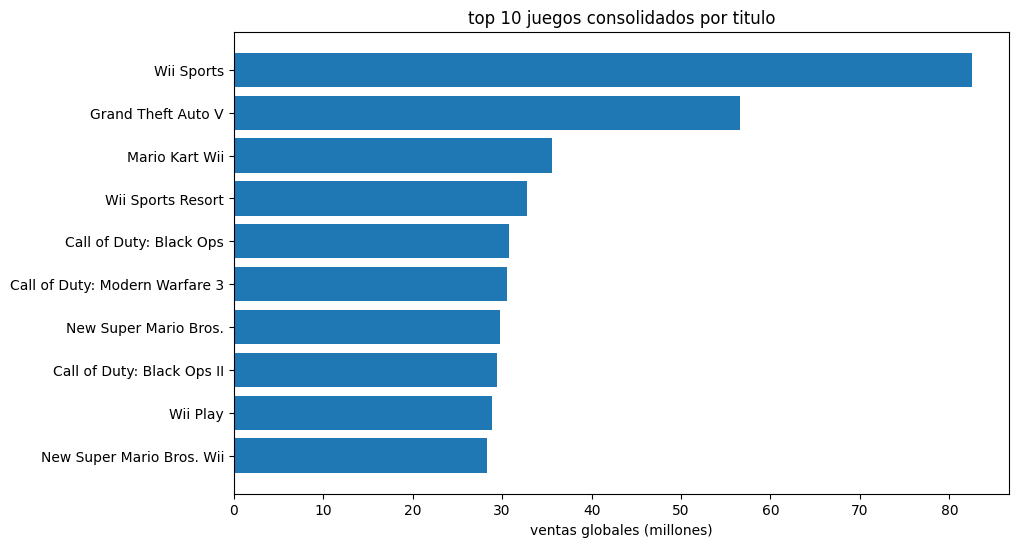

In [11]:
top10_consolidated = (
    df.groupby("Name")["Global_Sales"]
    .sum()
    .reset_index()
    .sort_values(by="Global_Sales", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
plt.barh(top10_consolidated["Name"][::-1], top10_consolidated["Global_Sales"][::-1])
plt.xlabel("ventas globales (millones)")
plt.title("top 10 juegos consolidados por titulo")
plt.show()

## top 10 consolidado por franquicia
para entender mejor el exito a largo plazo, creamos una funcion que asigna cada juego a una franquicia (ej. 'gta v' y 'gta: san andreas' pertenecen a 'grand theft auto'). luego, agrupamos las ventas globales por franquicia. este enfoque muestra que marcas como super mario o pokemon tienen un poder comercial inmenso que va mas alla de un solo titulo, consolidando su exito a lo largo de multiples entregas.

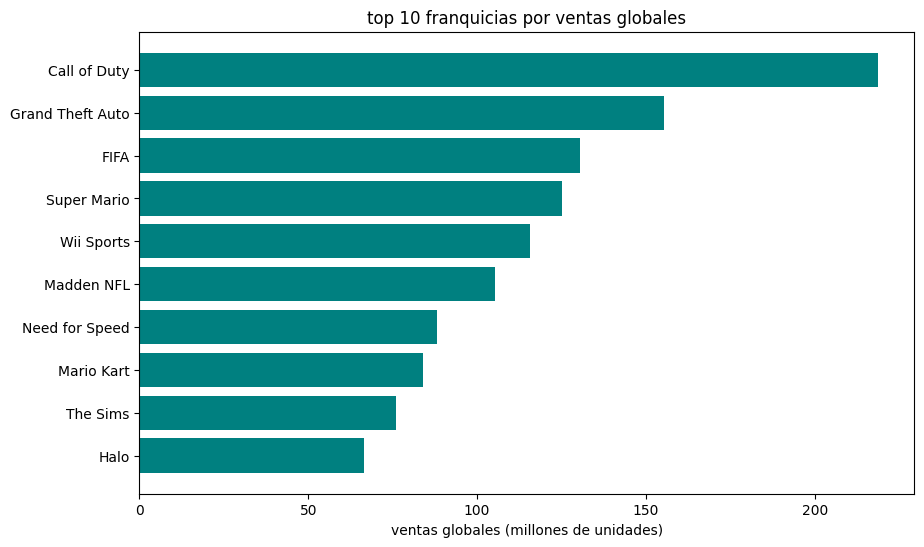

In [12]:
# unificar nombres de franquicias para evitar que se separen por ediciones/plataformas
def assign_franchise(name):
    name = str(name).lower()
    if "minecraft" in name:
        return "Minecraft"
    elif "grand theft auto" in name or "gta" in name:
        return "Grand Theft Auto"
    elif "pokemon" in name or "pokémon" in name:
        return "Pokemon"
    elif "fifa" in name:
        return "FIFA"
    elif "madden" in name:
        return "Madden NFL"
    elif "call of duty" in name:
        return "Call of Duty"
    elif "need for speed" in name:
        return "Need for Speed"
    elif "super mario" in name or "new super mario" in name or "mario bros" in name:
        return "Super Mario"
    elif "mario kart" in name:
        return "Mario Kart"
    elif "zelda" in name or "legend of zelda" in name:
        return "The Legend of Zelda"
    elif "sonic" in name:
        return "Sonic the Hedgehog"
    elif "halo" in name:
        return "Halo"
    elif "the sims" in name or "sims" in name:
        return "The Sims"
    elif "wii sports" in name:
        return "Wii Sports"
    elif "wii fit" in name:
        return "Wii Fit"
    elif "wii play" in name:
        return "Wii Play"
    elif "red dead" in name:
        return "Red Dead"
    elif "gran turismo" in name:
        return "Gran Turismo"


# crear columna de franquicia
df["Franchise"] = df["Name"].apply(assign_franchise)

# ranking top 10 por franquicia
franchise_sales = (
    df.groupby("Franchise")["Global_Sales"]
    .sum()
    .reset_index()
    .sort_values(by="Global_Sales", ascending=False)
    .head(10)
)

# grafico
plt.figure(figsize=(10,6))
plt.barh(franchise_sales["Franchise"][::-1], franchise_sales["Global_Sales"][::-1], color="teal")
plt.xlabel("ventas globales (millones de unidades)")
plt.title("top 10 franquicias por ventas globales")
plt.show()


## plataformas con mayores ventas acumuladas
aqui analizamos que consolas han generado mas ventas de software a lo largo del tiempo. agrupamos las ventas globales por plataforma y ordenamos de mayor a menor. el grafico de barras nos permite ver claramente que plataformas como la ps2, xbox 360 y wii han sido ecosistemas de hardware extremadamente lucrativos para la venta de juegos.

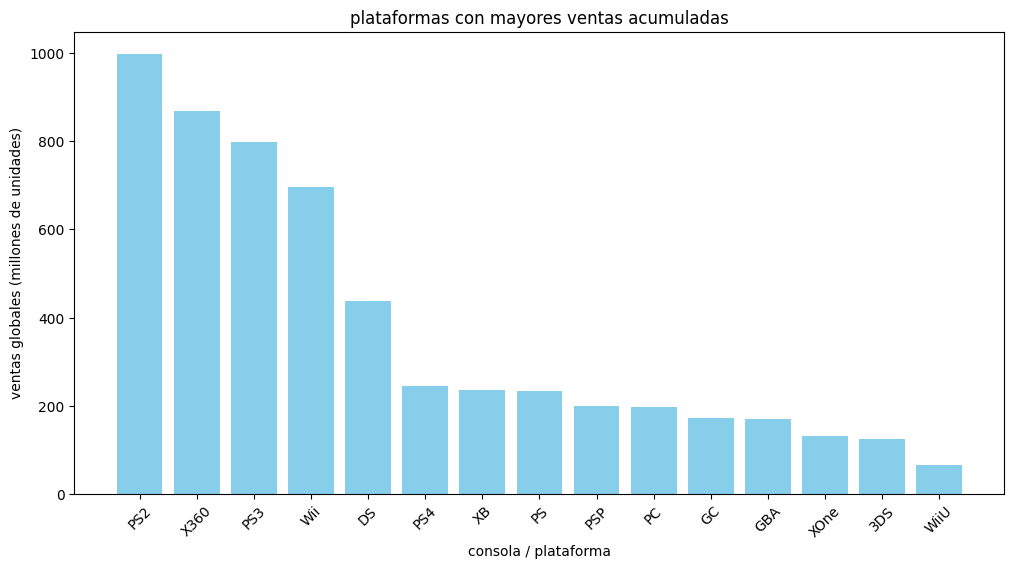

In [13]:
platform_sales = (
    df.groupby("Platform")["Global_Sales"]
    .sum()
    .sort_values(ascending=False)
)

# top 15 plataformas
top_platforms = platform_sales.head(15)

plt.figure(figsize=(12,6))
plt.bar(top_platforms.index, top_platforms.values, color="skyblue")
plt.xlabel("consola / plataforma")
plt.ylabel("ventas globales (millones de unidades)")
plt.title("plataformas con mayores ventas acumuladas")
plt.xticks(rotation=45)
plt.show()

## distribucion de generos por region
este analisis revela las preferencias culturales en distintos mercados. para cada region clave (norte america, europa y japon), calculamos la suma de ventas por genero y la visualizamos en un grafico de torta. los resultados muestran claras diferencias: mientras en japon dominan los juegos de rol, en occidente prefieren la accion y los deportes.


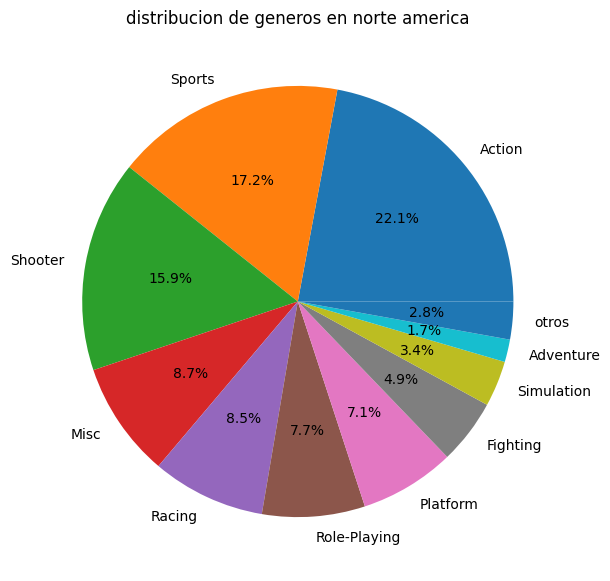

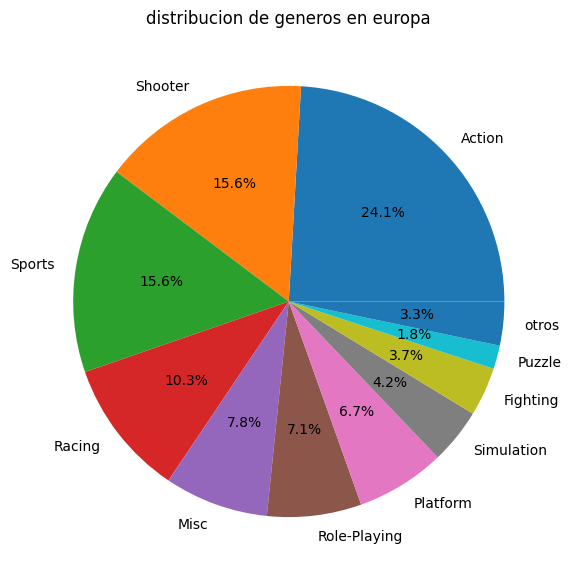

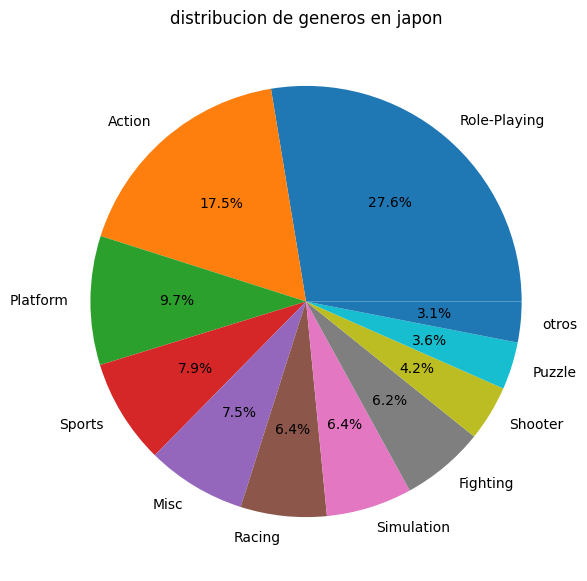

In [14]:

for region, col in {"norte america":"NA_Sales", "europa":"EU_Sales", "japon":"JP_Sales"}.items():
    if col in df.columns:
        genre_sales = df.groupby("Genre")[col].sum().sort_values(ascending=False)
        top_genres = genre_sales.head(10)
        others = genre_sales.iloc[10:].sum()
        labels = list(top_genres.index)
        sizes = list(top_genres.values)
        if others > 0:
            labels.append("otros")
            sizes.append(others)
        plt.figure(figsize=(7,7))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%')
        plt.title(f"distribucion de generos en {region}")
        plt.show()

## participacion de publishers en ventas globales
este grafico de torta muestra que compañias dominan el mercado del software. agrupamos las ventas globales por publisher y visualizamos la cuota de mercado de los 10 principales, agrupando el resto en 'otros'. nintendo emerge como lider indiscutible, seguido por electronic arts y activision, lo que demuestra la concentracion del poder en unas pocas grandes empresas.

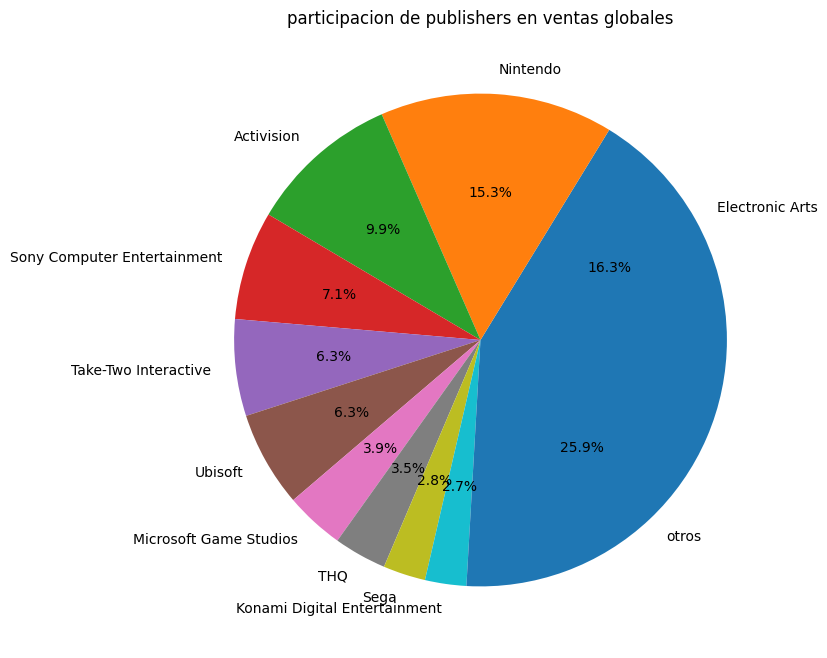

In [15]:

publisher_sales = df.groupby("Publisher")["Global_Sales"].sum().sort_values(ascending=False)
top_pub = publisher_sales.head(10)
others = publisher_sales.iloc[10:].sum()
labels = list(top_pub.index)
sizes = list(top_pub.values)
if others > 0:
    labels.append("otros")
    sizes.append(others)
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("participacion de publishers en ventas globales")
plt.show()

## ventas globales por año (hasta 2016)
para observar la evolucion del mercado, creamos un grafico de lineas que muestra la suma de las ventas globales por año de lanzamiento. filtramos los datos hasta 2016 para evitar informacion incompleta de años mas recientes. el grafico revela una 'era dorada' de ventas entre 2008 y 2009, seguida de una tendencia a la baja, posiblemente debido a la transicion a nuevas consolas y al auge de los juegos digitales no reflejados en este dataset.



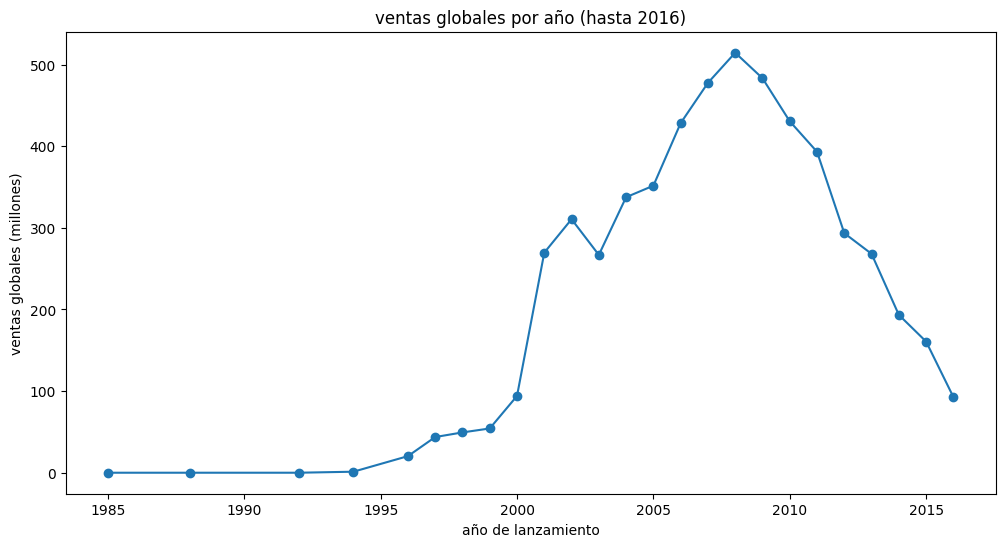

In [16]:
# ventas globales por año (filtrando hasta 2016)
if "Year_of_Release" in df.columns:
    yearly = (
        df.dropna(subset=["Year_of_Release"])
        .groupby("Year_of_Release")["Global_Sales"]
        .sum()
    )
    yearly = yearly[yearly.index <= 2016]  # filtra años confiables
    
    plt.figure(figsize=(12,6))
    plt.plot(yearly.index, yearly.values, marker='o')
    plt.xlabel("año de lanzamiento")
    plt.ylabel("ventas globales (millones)")
    plt.title("ventas globales por año (hasta 2016)")
    plt.show()

    



## comparacion de ventas: rockstar north vs treyarch
este analisis compara las estrategias de dos desarrolladores de exito. primero, filtramos el dataset para obtener solo los juegos de rockstar north y treyarch. luego, visualizamos las ventas por juego para rockstar north, destacando la dominancia de 'gta v'. finalmente, un grafico de barras compara las ventas totales acumuladas de ambos, mostrando que, a pesar de sus diferentes enfoques (mega-exitos esporadicos vs. entregas anuales), han alcanzado un exito comercial similar.

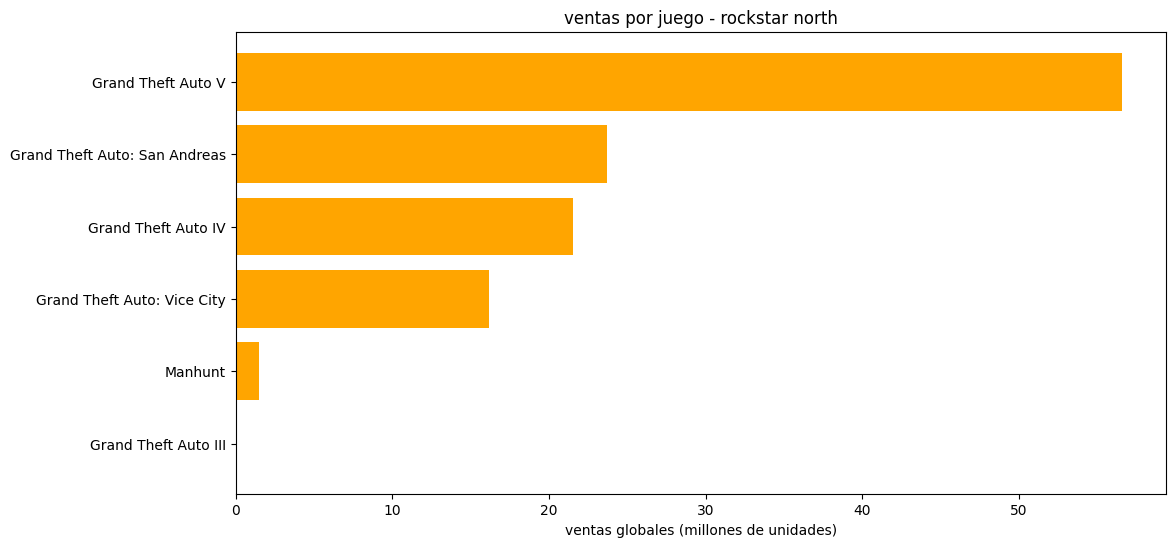

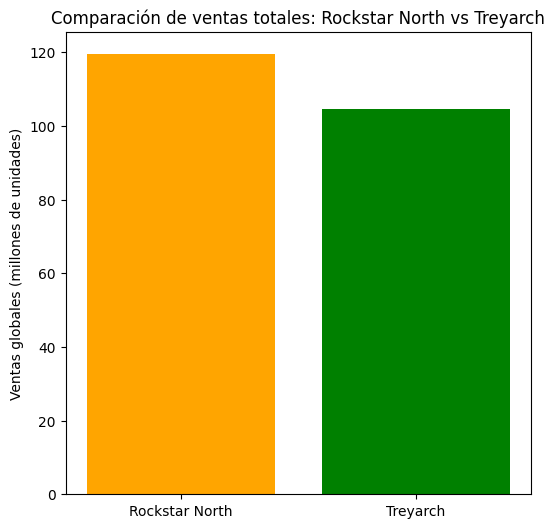

In [17]:

# filtrar developers
rockstar_dev = df[df["Developer"].str.contains("Rockstar North", case=False, na=False)]
treyarch_dev = df[df["Developer"].str.contains("Treyarch", case=False, na=False)]

# ventas por titulo de rockstar north
rockstar_games = rockstar_dev.groupby("Name")["Global_Sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
plt.barh(rockstar_games.index[::-1], rockstar_games.values[::-1], color="orange")
plt.xlabel("ventas globales (millones de unidades)")
plt.title("ventas por juego - rockstar north")
plt.show()

# Calcular ventas totales
rockstar_total = rockstar_dev['Global_Sales'].sum()
treyarch_total = treyarch_dev['Global_Sales'].sum()

# Datos para el gráfico
developers = ["Rockstar North", "Treyarch"]
total_sales = [rockstar_total, treyarch_total]

# Gráfico de comparación
plt.figure(figsize=(6,6))
plt.bar(developers, total_sales, color=["orange", "green"])
plt.ylabel("Ventas globales (millones de unidades)")
plt.title("Comparación de ventas totales: Rockstar North vs Treyarch")
plt.show()


# hallazgos clave del analisis
- el poder de las franquicias: la lealtad a la marca domina las ventas a largo plazo.
si bien juegos individuales como Wii sports lideran las ventas historicas por ser un fenomeno unico incluido con una consola, el analisis de franquicias revela una verdad mas profunda: el exito sostenido pertenece a las marcas consolidadas. Super mario demuestra ser la franquicia mas poderosa con mas de 300 millones de unidades vendidas, seguida de cerca por gigantes como Call of duty y Pokemon. esto indica que la estrategia de crear secuelas y expandir universos (como hace Grand theft auto) genera una base de fans leal que garantiza ventas millonarias con cada nuevo lanzamiento.

- el ecosistema de nintendo: doble dominio en hardware y software.
nintendo no solo es el publisher con la mayor participacion en ventas globales (29.6%), sino que tambien ha creado algunas de las plataformas de hardware mas vendidas de la historia, como la Wii y la Ds. esta doble fortaleza crea un ecosistema muy rentable: nintendo produce las consolas y, a su vez, desarrolla los juegos mas vendidos para ellas (como Mario kart o Wii sports), otorgandole un control del mercado dificil de replicar.

- preferencias regionales claras: el reflejo de la cultura en los videojuegos.
el analisis por genero y region muestra diferencias culturales muy marcadas. en japon, el genero Role-playing (rpg) es el rey indiscutible con un 27.4% del mercado. en cambio, en norteamerica y europa dominan los generos de Accion, Deportes y Shooter. esta divergencia demuestra que las estrategias de marketing y desarrollo deben ser adaptadas localmente, ya que un exito en un continente no garantiza su aceptacion en otro.

- la "era dorada" y la debil correlacion con las criticas.
el grafico de ventas anuales muestra un crecimiento explosivo que alcanzo su punto mas alto entre 2008 y 2009, coincidiendo con el auge de la Ps2, Wii y Ds. sin embargo, el analisis de correlacion revela que la relacion entre la puntuacion de la critica (critic_score) y las ventas globales (global_sales) es sorprendentemente debil (coeficiente de ~0.24-0.27). aunque una mala nota es perjudicial, una nota excelente no garantiza el exito comercial, sugiriendo que el marketing y la marca son igual o mas importantes.

- estrategias de desarrollador: el exito de un gigante (rockstar north) se basa en una sola franquicia.
al comparar desarrolladores, Rockstar north debe casi todo su exito a la franquicia Grand theft auto, donde Gta v representa casi la mitad de sus ventas. esto demuestra una estrategia de alto riesgo y alta recompensa, enfocada en producir mega-exitos cada varios años. en contraste, Treyarch, con ventas totales similares, es conocido por su trabajo en multiples entregas de Call of duty, lo que sugiere un modelo de produccion mas constante y distribuido.